# Sexual Assault Coverage - Walla! News

## Table of Notebook Contents

1. Imports cell
2. Dataset Construction
    <ol>
  <li>Scrape titles of 2019 articles</li>
  <li>Scrape titles of full dataset (2016-2019)</li>
  <li>Normalize titles</li>
  <li>Find sexaul assault related articles</li>
  <li>Scrape page content for the identified articles</li>
  <li>Normalize full article content</li>
  <li>Manually filter articles</li>
  <li>Separate high profile and standard coverage</li>
  <li>Fetch verbs and adjectives in all articles</li>
  <li>Final save/load of data before analysis</li>
    </ol>
2. Anaylsis
    <ol>
  <li>Hebrew Stopwords</li>
  <li>Wordcloud</li>
  <li>Lawyer mentions</li>
  <li>Gendered Verbs</li>
  <li>Gendered Adjectives</li>
  <li>Topic Modeling</li>
    </ol>
3. Utility
    <ol>
<li>Save files to text</li>
<li>Test HebrewNLP results</li>
    <ol>

In [1055]:
# web scraping 
import time #for pausing the scraper
from bs4 import BeautifulSoup, SoupStrainer #for reading and parsing html
import requests #for requesting a link's html code
from tqdm import tqdm #for progress bar to keep track of iterator time estimate
getattr(tqdm, '_instances', {}).clear() # to make it stay in one line (learned it too late)

# for wordcloud
from wordcloud import WordCloud
from bidi.algorithm import get_display

# for plotly
import plotly.express as px
import plotly.graph_objects as go

# for presenting flourish visualization
from IPython.core.display import display, HTML

# general
import pandas as pd 
import numpy as np
import pickle
import matplotlib.pyplot as plt

# identification to scraped websites
headers = {"user-agent" : "Chrome/84.6.35.5045 (Windows NT 10.0; Win64; x64)",
            "from": "Tom, Student at Minerva working on a university project. Contact me at tom.kremer@minerva.kgi.edu)"}

## Dataset Construction

### Dataset Construction / Scrape Titles of 2019

In [20]:
'''
This code goes through a webpage of Walla news archive in the format
'https://news.walla.co.il/archive/1?year=2020&month=3&page=1' after it was parsed by BeautifulSoup
and extracts the titles, subtitles, reporter, date, and links of all 50 articles in the page.
'''

def extract_titles(soup): 

    # an array that will contain all new articles for the page
    page_rows = []
    
    # find the part of the page with all article links
    all_content = soup.find("div", class_="css-18xwv1d")

    # get all links to items
    all_links = all_content.find_all("a",href=True)
    link_urls = [l['href'] for l in all_links]
        
    # Look into all article 'boxes' in the page
    all_groupings = all_content.find_all("div", class_="content")

    # for each article
    for i, grouping in enumerate(all_groupings):
        # get title, subtitle, reporter name, and date publisjed
        title = grouping.find("h3").get_text()
        subtitle = grouping.find("p").get_text()
        reporter = grouping.find('div', class_='author').get_text()
        date = grouping.find('div', class_='pub-date').get_text()
        
        # make a data dictionary that will be written into the csv
        row = { "date": date,
                "title": title,
                "subtitle": subtitle,
                "reporter": reporter,
                "link": link_urls[i]}
        
        # fix the first row's reporter name which is not extracted simply by using the get text on the div
        if i==0:
            row['reporter'] = ''.join(e for e in reporter if (e==' ' or (not e.islower() and e.isalnum() and not e.isnumeric())))
        
        page_rows.append(row)
        
    return(page_rows)

In [383]:
'''
This code finds all of the news pages of a given year. Every page has 50 articles and
a link to the next page, except for the last one. This block of code visits the first
page of the category, scrapes it using the function above, then finds the link to the 
next page and visits it until all pages for that year are scraped.  
'''
# an array that will contain the scraped dataset
all_rows=[]

# an array to hold page URLs to visit
pages=[]

# A counter to monitor which URL should be visited next
counter = 0

# for each month
for m in tqdm(range(1,13)):
    # set up the first URL based on the month, page=1
    start_page = 'https://news.walla.co.il/archive/1?year=2019&month='+str(m)+'&page=1'
    
    # add it to the list of pages to scrape
    pages.append(start_page)
    
    while pages[counter]: # while there are still pages left to scrape

        # rest scraper for a long time to be safe
        time.sleep(11)

        # request the page html
        #print('scraping:', pages[counter])
        page = requests.get(pages[counter], headers= headers)
        soup = BeautifulSoup(page.content, "html.parser")
        
        # scrape info of articles on that apge
        new_rows = extract_titles(soup)
        all_rows += new_rows

        # find link to the next page
        next_ = soup.find("a", class_="next walla-icon-next")

        # if a link exists, add it to the list of pages to visit and up the counter
        if next_ is not None:
            next_page = next_['href']
            pages.append(next_page)
            counter += 1

        # else, break while loop if the page has no next page and move to next month
        else:
            counter+=1
            break

  8%|▊         | 1/12 [01:53<20:49, 113.63s/it]

starting a new month


 17%|█▋        | 2/12 [03:30<18:07, 108.71s/it]

starting a new month


 25%|██▌       | 3/12 [05:10<15:54, 106.03s/it]

starting a new month


 33%|███▎      | 4/12 [06:50<13:53, 104.24s/it]

starting a new month


 42%|████▏     | 5/12 [08:46<12:33, 107.60s/it]

starting a new month


 50%|█████     | 6/12 [10:43<11:03, 110.61s/it]

starting a new month


 58%|█████▊    | 7/12 [12:40<09:21, 112.32s/it]

starting a new month


 67%|██████▋   | 8/12 [14:22<07:17, 109.27s/it]

starting a new month


 75%|███████▌  | 9/12 [15:48<05:07, 102.50s/it]

starting a new month


 83%|████████▎ | 10/12 [17:46<03:34, 107.14s/it]

starting a new month


 92%|█████████▏| 11/12 [19:29<01:45, 105.82s/it]

starting a new month


100%|██████████| 12/12 [21:25<00:00, 107.15s/it]

starting a new month


### Dataset Construction / Scrape Titles of 4 Years 2016-2019 

In [24]:
'''
This code finds all of the news pages of a given year. Every page has 50 articles and
a link to the next page, except for the last one. This block of code visits the first
page of the category, scrapes it using the function above, then finds the link to the 
next page and visits it until all pages for that year are scraped.  
'''
# an array that will contain the scraped dataset
all_rows=[]

# an array to hold page URLs to visit
pages=[]

# A counter to monitor which URL should be visited next
counter = 0

# years
years = [2016, 2017, 2018, 2019]

# for each month
for y in years:
    print('Beginning to scrape ',y)
    for m in tqdm(range(1,13)):
        # set up the first URL based on the month, page=1
        start_page = 'https://news.walla.co.il/archive/1?year='+str(y)+'&month='+str(m)+'&page=1'
        # add it to the list of pages to scrape
        pages.append(start_page)

        while pages[counter]: # while there are still pages left to scrape

            # rest scraper for a long time to be safe
            time.sleep(2.7)

            # request the page html
            #print('scraping:', pages[counter])
            page = requests.get(pages[counter], headers= headers)
            soup = BeautifulSoup(page.content, "html.parser")

            # scrape info of articles on that apge
            new_rows = extract_titles(soup)
            all_rows += new_rows

            # find link to the next page
            next_ = soup.find("a", class_="next walla-icon-next")

            # if a link exists, add it to the list of pages to visit and up the counter
            if next_ is not None:
                next_page = next_['href']
                pages.append(next_page)
                counter += 1

            # else, break while loop if the page has no next page and move to next month
            else:
                counter+=1
                break

  0%|          | 0/12 [00:00<?, ?it/s]

Beginning to scrape  2016


  0%|          | 0/12 [00:00<?, ?it/s]

Beginning to scrape  2017


  0%|          | 0/12 [00:00<?, ?it/s]

Beginning to scrape  2018


  0%|          | 0/12 [00:00<?, ?it/s]

Beginning to scrape  2019


100%|██████████| 12/12 [08:26<00:00, 42.25s/it]


In [29]:
#write list of dictionaries into a datafrme
new_df = pd.DataFrame(all_rows) 

# save to file
#pickle.dump(new_df, open( "fouryeardata.p", "wb"))

# read from file 
# new_df = pd.read_pickle("./data/jan2020data.p") 

In [28]:
#preview!
new_df.tail()

,date,title,subtitle,reporter,link
18581,10:10 01/12/2019,עשרות טורבינות בגובה 200 מטר: התכנית שמאיימת ע...,ביישובים הדרוזים ברמת הגולן חוששים כי בישיבת ה...,אלי אשכנזי,https://news.walla.co.il/item/3326774
18582,09:55 01/12/2019,"תאונה קשה בגבעת זאב: אם ובתה התינוקת נהרגו, יל...","בתאונה הקשה בכביש 443, נהרגו ציפי בת ה-34 מנוו...","מאיה הורודניצ'אנו, בועז אפרת, לירן לוי ויואב א...",https://news.walla.co.il/item/3326732
18583,06:00 01/12/2019,"מעשנים הרבה, מתחסנים פחות: נתוני הבריאות של הי...",דוח המכון הלאומי לחקר מדיניות הבריאות מגלה שיפ...,בועז אפרת,https://news.walla.co.il/item/3326736
18584,06:00 01/12/2019,שנה שנייה ברציפות: עלייה במספר נשאי האיידס החד...,"לרגל יום האיידס הבינלאומי, חושף דוח משרד הבריא...",בועז אפרת,https://news.walla.co.il/item/3326735
18585,05:25 01/12/2019,"סערה מתקרבת: הגשמים ישובו לקראת הערב, חשש לשיט...","הטמפרטורות מתקררות לקראת יממה סוערת, ומה שיתחי...",יואב איתיאל,https://news.walla.co.il/item/3326740


### Dataset Construction / Normalize Titles

In [30]:
'''
get an array of normalized words without punctuation using the HebrewNLP API.
'''

# an array that hold the new column with normalized words per article
words_column = []

ignore = ['מ#', # values returned by the API for numbers
         'ג#'] 

for i in tqdm(range(new_df.shape[0])): # iterate over all rows
    # rest API
    time.sleep(1)
    
    # create request object for API
    request = {
        'token': 'EGxhAVjlYSoRNsN',
        'readable': False,
        'paragraph':  new_df.title[i]+'. '+new_df.subtitle[i]
    }
    
    # get result from API
    result = requests.post('https://hebrew-nlp.co.il/service/Morphology/Analyze', json=request).json()

    # an array that will host all words in the text
    all_words =  []
    for sentence in result:
        for word in sentence:
            # word[0] is the API's best suggestion, 'baseWord' is the normalized word
            all_words.append(word[0]['baseWord']) 

    # remove numbers
    clean_words = [c for c in all_words if len(c)>1 and c not in ignore]
    joined = ' '.join(clean_words) # make into a long string for saving in the DF
    words_column.append(joined)
    
new_df.loc[:,'norm_words'] = words_column # create the new column

100%|██████████| 18586/18586 [3:45:11<00:00,  1.38it/s]  


#### Load saved data
after adding normalized words column via HebrewNLP API

In [33]:
# save to file
# pickle.dump(new_df, open( "fouryeardata_norm.p", "wb"))

# read from file 
#new_df = pd.read_pickle("./data/fouryeardata_norm.p") 

### Dataset Construction / Find sexaul assault related articles

So far we got all articles, now we want to extract only those related to the analysis.

In [62]:
'''get an array of normalized words that are indicative of sexual assault stories
   and compare it against the normalized words colunmn per article created above'''

relevant_words = 'פדופיליה פדופיל מין מיני מינית אינטימיים אונס מגונים מגונה סקס אנס נאנס נאנסה שכב'
# I might remove two words here that made significant amount of noise 
# and might try adding them in conjuction with some other words.

# get the normalized version of these words to compare with the normalized words column
request = {
    'token': 'EGxhAVjlYSoRNsN',
    'readable': False,
    'paragraph':  relevant_words
}

test_result = requests.post('https://hebrew-nlp.co.il/service/Morphology/Analyze', json=request).json()

# extract best guess for the normalized form of each word
sexual_assault_words =  []
for sentence in test_result:
    for word in sentence:
        sexual_assault_words.append(word[0]['baseWord'])
        
sexual_assault_words.remove('.') # remove period which gets added in automatically
print(sexual_assault_words) # the words

['פדופיליה', 'פדופיל', 'מינ', 'מיני', 'מינה', 'אינטימי', 'אונס', 'מגונה', 'גונה', 'סקס', 'אנס', 'אינס', 'נאנס', 'שכב']


In [63]:
'''Search which titles or subtitles contain these words'''

# array to contain indices of articles
indices=[]

# iterate over the lists of all words in each article
for i, text in enumerate(new_df.norm_words.values):
    words = text.split(' ')  # make into a list of words again
    if any(sx in words for sx in sexual_assault_words): # if any word of the above
        indices.append(i)

print(f'Found {len(indices)} articles with SA words')

# The script from hereremove cases where unrelated words get identified
# (false positives) because their normalized form is sort of like 'sex' 

should_not_contain = ['מינה',
                       'נתניהו', 
                      'מינתה',
                     'מניין']

remov = []
for i in indices:
    if (any(w in new_df.title[i].split(' ') for w in should_not_contain) or
        any(w in new_df.subtitle[i].split(' ') for w in should_not_contain)):
            remov.append(i)

print(len(remov), 'articles to remove')
[indices.remove(r) for r in remov]
print(len(indices), 'articles after removal')

Found 1330 articles with SA words
35 articles to remove
1295 articles after removal


In [76]:
# create a new df with only sexual-assault related cases
full_clean_df = new_df.loc[indices,:]

(1295, 7)

### Dataset Construction / Scrape page content for the identified articles

In [1111]:
# # # test with one page
# url=''

# # request the page html
# page = requests.get(url, headers= headers)
# page_content = page.content

# # filter only to look at the core content section
# only_content = SoupStrainer("section", class_='article-content')

# # get page
# soup = BeautifulSoup(page_content, "html.parser", parse_only=only_content)

# # remove text in links which leads to other articles
# for a in soup.findAll('a', href=True):
#     a.extract()
      
# # collect all the <p> texts
# p_tags = soup.findAll('p')

# # # get only text from all paragraphs
# real_ps = [p for p in p_tags if len(p.get_text())>100]
# dirty_text = [str(item.get_text()) for item in real_ps if item]

# # remove links to other stories that are not caught by the above <a> extract
# to_keep=[]
# for txt in dirty_text:
#     if not txt.endswith('...'):
#         to_keep.append(txt)
        
# ' '.join(to_keep)

In [68]:
'''
This code scrapes the content of Walla! news articles whose links are at full_before_remove dataframe.
'''

# how many pages to scrape
#pages_to_scrape = clean_df.shape[0]
pages_to_scrape = full_clean_df.shape[0] #modification for the full dataset

# a list to compile text data that we're scraping
full_text_data = []

# filter only to look at the core content section
only_content = SoupStrainer("section", class_='article-content')

# loop through the article links
for url in tqdm(full_clean_df['link'].values[:pages_to_scrape]): #modified from clean_df to full
    
    # rest scrapper
    time.sleep(round(3+np.random.random(),1))
    
    # request the page html
    page = requests.get(url, headers= headers)
    page_content = page.content
    soup = BeautifulSoup(page_content, "html.parser", parse_only=only_content)
    
    # remove text in links which leads to other articles
    for a in soup.findAll('a', href=True):
        a.extract()
        
    # collect all the <p> texts
    p_tags = soup.findAll('p')
    
    # remove short news flashes
    real_ps = [p for p in p_tags if len(p.get_text())>100]
    
    # get only text from all paragraphs
    dirty_text = [str(item.get_text()) for item in real_ps if item]
    
    # remove links to other stories that are not caught by the above <a> extract
    to_keep=[]
    for txt in dirty_text:
        if not txt.endswith('...'):
            to_keep.append(txt)
        
    full_text_data.append(' '.join(to_keep))

100%|██████████| 1295/1295 [2:03:36<00:00,  5.73s/it] 


In [78]:
# add original article content as a column

#clean_df.loc[:,'full_text'] = full_text_data # create the new column
full_clean_df.loc[:,'full_text'] = full_text_data # create the new column

### Dataset Construction / Normalize full article content

In [70]:
'''
This bit will normalize the article content using HebrewNLP in the same way
used for the titles and subtitles thus far to identify artiles.
'''
# an array to host all clean text
clean_text_data = []

# values returned by the API for numbers
ignore = ['מ#', 
         'ג#'] 

for orig_text in tqdm(full_text_data):  
    # rest API
    time.sleep(3)
    
    # remove the 'for further reading' expression that appears in all pieces
    cleaner_text = orig_text.replace('NEWS', '').replace('לקריאה נוספת', '').replace('עוד בוואלה', '')
    
    # create request object for API
    request = {
        'token': 'EGxhAVjlYSoRNsN',
        'readable': False,
        'paragraph':  cleaner_text
    }
    
    # get result from API
    result = requests.post('https://hebrew-nlp.co.il/service/Morphology/Analyze', json=request).json()

    # an array that will host all words in the text
    all_words =  []
    for sentence in result:
        for word in sentence:
            # word[0] is the API's best suggestion, 'baseWord' is the normalized word
            all_words.append(word[0]['baseWord']) 

    # remove numbers and two-letter words which are always stopwords
    clean_words = [c for c in all_words if len(c)>2 and c not in ignore]
    joined = ' '.join(clean_words) # make into a long string for saving in the DF
    
    # append clean string
    clean_text_data.append(joined)

100%|██████████| 1295/1295 [1:48:39<00:00,  5.03s/it] 


In [79]:
# add normalized full text column to dataframe
full_clean_df.loc[:,'norm_full_text'] = clean_text_data

In [121]:
# add index column to preserve numbers before manual review
full_clean_df.loc[:,'original_index'] = range(full_clean_df.shape[0])

In [81]:
# save to file
pickle.dump(full_clean_df, open( "./data/fouryear_data_full_before_filtering.p", "wb"))

# read from file 
# clean_df = pd.read_pickle("./data/2019datafull.p") 

### Dataset Construction / Manually Filter Articles

In [720]:
# view a specific article
ind = 494 
final_df.subtitle.values[ind]#+'\n'+full_clean_df.full_text.values[ind]

'בית הדין המשמעתי של אוניברסיטת בן גוריון אסר על הסטודנטית להמשיך את לימודי הדוקטורט שלה. אך המרצה, שבהכרעת הדין יוחסו לו אמירות בעלות אופי מיני, נוקה לגמרי מהפרשה. כל זאת, ברקע דוח המבקר שהתריע מטיוח עבירות משמעת באקדמיה'

In [722]:
# look at titles
for i in range(final_df.shape[0]):
    print(i, final_df.index.values[i], final_df.title.values[i])

0 0 אישום: אנס את אחותו מגיל חמש - וגרם לה לבלוע תרופות "כדי שתמות"
1 1 אחרי שלושה חודשים: נסגר תיק החקירה בפרשת "אלנבי 40"
2 3 "נמלט מהחוק": הקהילה היהודית בדרום אפריקה קוראת לרב ברלנד לעזוב
3 4 כתב אישום: בן 38 ביצע מעשי סדום בנער בן 13
4 7 אחרי שלא נמצאה תשתית ראייתית: תיק החקירה נגד ינון מגל ייסגר
5 8 ראש העיר אשקלון החשוד באונס שוחרר למעצר בית: "רוצה לאשתי וילדיי"
6 9 מסתמן: לא יוגשו כתבי אישום בגין אונס בפרשת אלנבי 40
7 11 חשד: גבר מבני ברק כלא ואנס את אחותו במשך יותר משנה  בסיוע האב
8 12 "אמר שסקסיזם הוא שיח סביר": נחשף מכתב המתלוננת נגד ריטמן לאלשיך
9 13 מעצרו של איתמר שמעוני הוארך; על החשד באונס: "היחסים היו בהסכמה"
10 14 החרדי שגזז את פאותיו במחאה על רצח שירה בנקי חשוד בפדופיליה
11 15 המשטרה ממליצה להעמיד לדין את מפקד כלא איילון בגין אונס עובדת שב"ס
12 16 נשיאת העליון: "לא ייתכן שיסיתו נגד שופט בגלל עונש שגזר"
13 17 מעצרו של שמעוני הוארך בשישה ימים; הבכיר שנעצר: מנכ"ל עיריית אשקלון
14 19 מתפללים לשחרורו: מוקד טלפוני לקריאת תהילים למען איתמר שמעוני
15 20 למרות שלא הביע חרטה: 

263 334 "ראש מועצת גוש עציון פגע באישה ושילם? לתת לעניין לשקוע"
264 335 ממצאי ה-DNA הובילו להתפתחות בחקירה: אזרח זר חשוד באונס באילת
265 336 האישומים חשפו: נאנסה ע"י אביה החורג  והותקפה מינית בידי האב הביולוגי
266 337 צלם הדוגמנות מנתניה חשוד שהתחזה לאישה בפייסבוק  ואנס נערה
267 339 "עוף לי מהפנים - אתה סוטה": בכיר במשרד התקשורת חשוד בהטרדה מינית
268 340 מוזיקאי מקהילת העבריים חשוד שאנס בת 13 יחד עם שלושה מחבריו
269 341 בן 37 מנתניה חשוד שהתחזה לצלם דוגמנות ושכנע נערה לשכב עמו
270 342 אישום: איימו על נערה ברשת  וסחטו ממנה יחסי מין ומעשה סדום
271 343 "ביצע מעשי סדום  וקנה מתנות": מאמן כדורעף נאשם שתקף נער בן 15
272 344 הותר לפרסום שמו של הגניקולוג מהשרון המואשם באונס מטופלות
273 345 ספר מוכר מכיכר המדינה בתל אביב נעצר בחשד לאונס שתי נשים
274 346 נהגו לשעבר של ראש הממשלה הורשע באונס ובעבירות מין בילדות
275 347 חשד לרצח בנצרת: גבר בן 38 נורה למוות בעיר
276 349 במרכז ירושלים, בצהרי היום: בן 33 חשוד באונס צעירה ברחוב
277 350 תפנית דרמטית בחקירה: אזרח זר הנאשם בפריצה חשוד באונס נערה ב-20

In [135]:
# Remove false positives from the indices based on the above

remov = [2, 5, 6, 10, 18, 27, 28, 29, 34, 41, 44, 48, 55, 57, 59, 68, 70, 77, 78, 80, 82, 83, 85, 88, 89, 95, 98, 99, 100, 102,
        103, 112, 114, 115, 113, 122, 124, 126, 130, 135, 137, 138, 141, 151, 153, 154, 155, 161, 162, 169, 177, 181, 183, 186,
        188, 193, 194, 199, 206, 210, 212, 220, 221, 222, 223, 229, 231, 232, 234, 235, 241, 242, 243, 245, 246, 248, 255,
        256, 260, 263, 264, 265, 268, 270, 272, 275, 276, 279, 282, 283, 284, 289, 292, 294, 295, 296, 300, 302, 303, 304,
        307, 308, 323, 325, 329, 330, 332, 333, 338, 348, 354, 357, 358, 361, 368, 370, 373, 376, 377, 379, 383, 386, 389, 
        390, 394, 400, 399, 401, 411, 417, 423, 426, 428, 441, 442, 444, 445, 446, 451, 452, 453, 454, 455, 459, 460, 462, 
        464, 471, 472, 473, 479, 486, 492, 496, 502, 503, 506, 508, 513, 517, 520, 523, 529, 533, 545, 547, 548, 555, 560, 
        562, 568, 573, 574, 575, 583, 586, 587, 589, 593, 599, 600, 602, 608, 610, 613, 620, 622, 623, 625, 627, 628, 630, 
        632, 634, 635, 638, 639, 640, 646, 647, 657, 659, 662, 666, 670, 671, 672, 673, 679, 680, 690, 692, 696, 700, 706, 
        708, 709, 710, 711, 712, 713, 716, 720, 721, 722, 729, 730, 731, 733, 737, 739, 740, 742, 744, 746, 749, 753, 755,
        746, 762, 763, 764, 765, 773, 774, 777, 778, 782, 786, 790, 791, 792, 793, 794, 797, 799, 812, 813, 814, 819, 821,
        825, 827, 830, 832, 834, 837, 839, 840, 841, 844, 845, 846, 848, 849, 950, 851, 852, 855, 856, 857, 861, 863, 865, 
        866, 868, 871, 872, 874, 875, 877, 881, 884, 886, 888, 895, 899, 906, 907, 908, 910, 913, 917, 918, 920, 922, 923,
        926, 933, 936, 937, 939, 940, 942, 943, 944, 945, 946, 958, 959, 960, 969, 971, 972, 975, 977, 979, 982, 987, 990, 
        991, 992, 994, 995, 996, 998, 1003, 1006, 1009, 1010, 1011, 1013, 1014, 1015, 1016, 1019, 1021, 1024, 1027, 1028,
        1031, 1032, 1035, 1036, 1037, 1038, 1043, 1047, 1049, 1051, 1052, 1053, 1054, 1055, 1056, 1058, 1059, 1064, 1065,
        1066, 1069, 1070, 1072, 1075, 1076, 1077, 1078, 1081, 1085, 1088, 1090, 1093, 1097, 1098, 1101, 1102, 1103, 1105,
        1108, 1110, 1113, 1115, 1116, 1119, 1120, 1121, 1123, 1128, 1130, 1134, 1147, 1149, 1155, 1160, 1162, 1176, 1177, 
        1180, 1181, 1185, 1186, 1189, 1194, 1196, 1199, 1203, 1204, 1206, 1207, 1213, 1218, 1219, 1221, 1226, 1228, 1233,
        1234, 1235, 1237, 1244, 1245, 1246, 1248, 1249, 1250, 1252, 1264, 1256, 1261, 1267, 1269, 1274, 1275, 1278, 1283,
        1287, 1288, 1292]

len(remov)

#### When working with 'df' - only one Jan 2020:
25 results out of 304 articles. 7 false positives because of the following issues:
1. Mina --> can take the indices and check if 'mina' is in norm_words
2. Hatrada --> remove hatrada for all data.
3. Minyan --> can remove based on norm_words, probably few errors
4. Yahasim  --> that is noisy, but also one of the problematic cases. maybe should do a separate search for this one plus other words isha, nashim, hashud, etc. I can keep only if 'yahashey' or 'yahasim' in all_words or kiem/nihel yahasim.

Manual check of all articles showed there were no false negatives (i.e. no titles this did not detect)

#### When working with new_df - the entire 2020:
1. 245 after removing hatrada and yahasim, 348 with, and it seems after manually checking that most are false positives. So I'll exclude the two noisy words when getting more data.
2. Care with gender division - include something that covers kids/teenagers (looks like a significant amount...).
3. Main events - Malca leifer, 7 year old, british in cyprus. Spam terms: bibi, 'yahas', hatrada ed medina. 

I should probably drop 'hatrada' and 'yahas' for the final df because these cause lots of noise <--- I did.

### Dataset Construction / Separate high profile and standard coverage articles

In [734]:
''' did i miss anything from qualitative assessment? find all names that appear more than 5 times
'''

# celeb={}
# for wrds in final_df.subtitle.values: 
#         # create a count dictionary for it 
#         keys, values = np.unique(wrds.split(' '), return_counts=True)
#         temp_dict = dict(zip(keys, values))

#         # add it to the total counter 'word_counts'
#         celeb = {key: celeb.get(key, 0) + temp_dict.get(key, 0)
#               for key in set(celeb) | set(temp_dict)}

# # sort by word frequency 
# celeb_sorted = {k: v for k, v in sorted(celeb.items(), key=lambda item: item[1], reverse=True)}

# celeb_sorted

# look at articles with these names
# names = ['ריבקין', 'אלון', 'עידן', 'דוד', ' שי ', 'אילן', 'יוסף', 'כהן', 'נחמן']
# for i in range(final_df.shape[0]):
#     if any(name in final_df.subtitle.values[i] for name in names):
#         print(i, final_df.subtitle.values[i])
#         print()

# added one more to the list below

In [912]:
'''define all high-profile cases and find out indices that cover them by looking at the titles'''

# the names or keywords that are unique to high profile cases
high_profile= ['שמעוני', 'איבגי', 'ברלנד', 'בוכריס', 'קצב', 'ביטי', 'דני ביטון', 'אייל גולן',
               'נוה ', 'לייפר', 'יצחק כהן', 'קסטיאל' , 'ליצמן', 'ריטמן', 'שחם', 'קטוסה', 'קפריסין'] 

# make a count dictionary
high_profile_count = {el:0 for el in high_profile}

# store indices of high profile articles
high_profile_indices = set()

# high profile
for i in range(full_clean_df.shape[0]):
    titles = full_clean_df.title.values[i]+' '+full_clean_df.subtitle.values[i]
    text = full_clean_df.full_text.values[i]
    for person in high_profile_count.keys():
        title_count = titles.count(person)
        if title_count >= 1: 
            high_profile_count[person]+=1
            high_profile_indices.add(i)
            
#   this bit involved looking at the count in the text, but was found to be unnecessary
#         text_count = text.count(person)
#         if title_count==0 and text_count>1:
#             print('Index:',i,'Title:', title_count, 'Text:', text_count, 'Person:', person)
#             print(full_clean_df.title.values[i])

# unify two keywords that aim to catch the same case
high_profile_count['דני ביטון'] += high_profile_count.get('אייל גולן')
high_profile_count.pop('אייל גולן',None)

high_profile_count['לייפר'] += high_profile_count.get('ליצמן')
high_profile_count.pop('ליצמן',None)

# print results
print(high_profile_count)
print(len(high_profile_indices), 'high profile articles')

{'שמעוני': 18, 'איבגי': 11, 'ברלנד': 52, 'בוכריס': 20, 'קצב': 46, 'ביטי': 5, 'דני ביטון': 6, 'נוה ': 12, 'לייפר': 18, 'יצחק כהן': 8, 'קסטיאל': 21, 'ריטמן': 10, 'שחם': 9, 'קטוסה': 17, 'קפריסין': 11}
255 high profile articles


In [367]:
# create high-profile column in the un-clean one

full_clean_df=full_clean_df.set_index('original_index')
high_profile = [1 if i in high_profile_indices else 0 for i in range(1295)]
full_clean_df.loc[:,'high_profile'] = high_profile

In [374]:
# all items marked for removal, minus those that are actually high profiles
new_remov = [i for i in remov if i not in high_profile_indices]
final_df = full_clean_df.copy()
final_df=final_df[~final_df.index.isin(new_remov)]  

In [375]:
# get month and year for articles
final_df.loc[:,'dt_date'] = pd.to_datetime(final_df.date, infer_datetime_format=True)
final_df.loc[:,'year'] = pd.DatetimeIndex(final_df['dt_date']).year
final_df.loc[:,'month']= pd.DatetimeIndex(final_df['dt_date']).month
final_df.drop(['date'], axis=1, inplace=True)

In [1048]:
''' remove extra ones found later in the process '''

# fix two full text that were not downloaded well for some reason
#final_df.drop[final_df.norm_full_text=='']
# final_df[final_df.norm_full_text==''] # to get original_index - 209, 681
# np.where(final_df.norm_full_text=='') # to get row number - 162, 534

# five spamming articles - for removal by row number
# np.where(final_df['title'].str.count('צריכים לדעת היום').values==1)

# drop row number 741, spam

# second pass for removal (row_num / original_index) after high_profile update
# 26/35, 34/45, 64/83, 95/127, 125/164, 129/168, 158/205, 242/307, 275/347, 318/406, 330/420, 336/429, 340/433, 341/433,
# 343/436, 344/437, 378/476, 404/506, 408/511, 411/515, 423/531, 475/596, 606/788, 609/789, 648/850, 677/894, 730/971, 
# 735/979, 746/999, 835/1143, 877/1200, 914/1253, 

In [387]:
print('Final size: ', final_df.shape)
final_df.head()

Final size:  (947, 11)


,title,subtitle,reporter,link,norm_words,full_text,norm_full_text,high_profile,dt_date,year,month
original_index,,,,,,,,,,,
0,אישום: אנס את אחותו מגיל חמש - וגרם לה לבלוע ת...,"תושב המרכז, בן 29, מואשם בשורה של עבירות מין ב...",גלי גינת,https://news.walla.co.il/item/2930403,אישומ אנס את אח גיל חמש גרמ בלע תרופה כדי מת ת...,"תושב המרכז, בן 29, מואשם בשורה של עבירות מין ב...",תושב מרכז הואשמ שורה עבירה מינ מעשה סדומ עוד ה...,0,2016-01-31 10:10:00,2016,1
1,"אחרי שלושה חודשים: נסגר תיק החקירה בפרשת ""אלנב...",פרקליטות תל אביב הודיעה לחשודים כי החליטה לסגו...,גלי גינת,https://news.walla.co.il/item/2929998,אחרי שלוש חודש נסגר תיק חקירה פרשה אלנבי 40 פר...,פרקליטות תל אביב הודיעה לחשודים כי החליטה לסגו...,פרקליטות אביב הודיע חשוד החליט סגר תיק נגד הוד...,0,2016-01-28 18:07:00,2016,1
3,"""נמלט מהחוק"": הקהילה היהודית בדרום אפריקה קורא...",לוואלה! NEWS נודע כי הרב הראשי במדינה ושורת אר...,יקי אדמקר,https://news.walla.co.il/item/2929505,נמלט חוק קהילה יהודי דרומ אפריקה קרא רב ברלנד ...,לוואלה! NEWS נודע כי הרב הראשי במדינה ושורת אר...,לוואלה נודע ראשי מדינה שורה ארגונ יהודי נוספ ה...,1,2016-01-27 18:06:00,2016,1
4,כתב אישום: בן 38 ביצע מעשי סדום בנער בן 13,"יעקב אינדיק, תושב בני ברק, עבר להתגורר לפני כמ...",גלי גינת,https://news.walla.co.il/item/2929085,כתב אישומ ביצע מעשי סדומ נער יעקב אינדיק תושב ...,"יעקב אינדיק, תושב בני ברק, עבר להתגורר לפני כמ...",יעקב אינדיק תושב בני ברק עבר התגורר לפני חודש ...,0,2016-01-26 15:19:00,2016,1
7,אחרי שלא נמצאה תשתית ראייתית: תיק החקירה נגד י...,המשטרה תמליץ לא להעמיד לדין את חבר הכנסת לשעבר...,יוסי אלי,https://news.walla.co.il/item/2928581,אחרי לא נמצא תשתית ראייתי תיק חקירה נגד ינונ ג...,המשטרה תמליץ לא להעמיד לדין את חבר הכנסת לשעבר...,משטרה המליצ העמיד חבר כנסת לשעבר נחשד הטרדה מי...,0,2016-01-25 11:24:00,2016,1


## Dataset Construction / Fetch verbs and adjectives in all articles

This section only contains the cells that fetch the verbs from HebrewNLP based on the above dataframe. After that, in the analysis section, there is code to take this raw file, make a sorted count out of it, remove stopwords, and plotting it.

In [664]:
def get_all_terms(original_text, partOfSpeech):
    ''' Takes un-normalized text as a long string, and the part of speech to be searched.
        Un-normalized text needed because in the normalized version gender is neutralizeid already.
        Calls on HebrewNLP to fetch all instances of this text identified as the PoS, and their gender.
        Returns two arrays, one for each gender, of the part of speech desired (e.g. verb)'''
    
    # array to hold results
    all_m_verbs, all_f_verbs = [], []
    
    for i in tqdm(range(len(original_text))):
        # rest API
        time.sleep(2)
        
        # get a result from API
        request = {'token': 'EGxhAVjlYSoRNsN', 'readable': False,
                   'paragraph':  original_text[i]}

        result = requests.post('https://hebrew-nlp.co.il/service/Morphology/Analyze', json=request).json()

        # arrays to store verbs
        row_m_verbs=[]
        row_f_verbs=[]

        # iterate over all words in the result
        for sentence in result:
             for word in sentence:
                best_option = word[0] # get the best-guess normalized word 
                if len(best_option['baseWord']) <= 1: # ignore punctuation
                    continue

                if best_option['partOfSpeech'] == partOfSpeech: # if a verb, add to respective array
                    if best_option['gender'] =='MALE':
                        row_m_verbs.append(best_option['baseWord'])

                    # add the suffix for feminine verbs for easy read
                    elif best_option['gender'] =='FEMALE':
                        row_f_verbs.append(best_option['baseWord']+'ה')

        all_m_verbs.append(' '.join(row_m_verbs))
        all_f_verbs.append(' '.join(row_f_verbs))
        
    return all_m_verbs, all_f_verbs


In [651]:
''' Get verbs from full contnet'''

### Full article
full_original_text = final_df.full_text.values

# array to store two new columns: all masculine/feminene verbs in the article
full_m_verbs, full_f_verbs = get_all_terms(full_original_text, 'VERB')

100%|██████████| 947/947 [29:45<00:00,  1.89s/it] 


In [665]:
''' Get verbs from Titles (not full content)'''
# a joint string for title and subtitle
titles_original_text = final_df.title.values+' '+final_df.subtitle.values

# array to store two new columns: all masculine/feminene verbs in the article 
titles_m_verbs, titles_f_verbs = get_all_terms(titles_original_text, 'VERB')

100%|██████████| 947/947 [36:48<00:00,  2.33s/it]


In [493]:
''' Get adjectives from full content'''
full_m_adj, full_f_adj = get_all_terms(full_original_text, 'ADJECTIVE')

## Dataset Construction / Final save-load of data before analysis

There are two dataframes being saved here. 

1. final_df - this is the dataframe derived above, without the verbs and adjectives per article fetched using HebrewNLP. This is what I used throughout the analyis part - I did not save the fetched results as columns, so the code is written in terms of this dataframe and the array that stored results.

2. full_scraped_df - this is final_df plus six extra columns, with the M and F verbs-in-text, verbs-in-titles, and adjectives-in-text that are used in the analysis section. The columns in it are the raw files fetched by in the above cells (full_m_verns, etc.). 

In [378]:
''' save and load final_df '''
# save to file
pickle.dump(final_df, open( "./data/final_df.p", "wb"))

# read from file 
final_df = pd.read_pickle("./data/final_df.p") 

In [1120]:
''' create full_scraped_df '''
# verify all same length
print(final_df.shape[0], len(full_m_verbs), len(full_f_verbs), len(titles_m_verbs),
      len(titles_f_verbs), len(full_m_adj), len(full_f_adj))

# make a copy of the previous df used throughout
full_scraped_df = final_df.copy()

# add columns
full_scraped_df.loc[:,'full_m_verbs'] = full_m_verbs
full_scraped_df.loc[:,'full_f_verbs'] = full_f_verbs
full_scraped_df.loc[:,'titles_m_verbs'] = titles_m_verbs
full_scraped_df.loc[:,'titles_f_verbs'] = titles_f_verbs
full_scraped_df.loc[:,'full_m_adj'] = full_m_adj
full_scraped_df.loc[:,'full_f_adj'] = full_f_adj

947 947 947 947 947 947


In [1121]:
# save full_scraped_df to file
pickle.dump(full_scraped_df, open( "./data/full_scraped_df.p", "wb"))

# load full_scraped_df from file 
full_scraped_df = pd.read_pickle("./data/full_scraped_df.p") 

## Analysis

### Analysis / Hebrew Stopwords

In [765]:
# based on list from https://github.com/gidim/HebrewStopWords

file = open('./data/heb_stopwords.txt', 'r', encoding="utf8")
with file:
    stopwords_raw = file.readlines()

stopwords=[s.rstrip() for s in stopwords_raw] # remove spaces left after reading

file = open('./data/heb_stopwords_full.txt', 'r', encoding="utf8")
with file:
    stopwords_raw = file.readlines()

stopwords_full=[s.rstrip() for s in stopwords_raw] # remove spaces left after reading

# create a normalized version of the stopwords
norm_stopwords = [normalize_stopwords(s) for s in stopwords]
norm_stopwords_full = [normalize_stopwords(s) for s in stopwords_full]

### Analysis / Word Cloud

In [767]:
# create a word counts dictionary across the corpus from the norm_words column
def unify_terms(dict_words, word1, word2):
    dict_words[word1] += dict_words.get(word2)
    dict_words.pop(word2,None)
    return dict_words

def final_letter(word):
    '''A function that fixes the final letter of a word for the correct form
       because in Hebrew some letters are written differently in the end of a word'''
    if word.endswith('מ'):
        word = word[:-1]+'ם'

    elif word.endswith('כ'):
        word = word[:-1]+'ך'

    elif word.endswith('נ'):
        word = word[:-1]+'ן'

    elif word.endswith('פ'):
        word = word[:-1]+'ף'

    elif word.endswith('צ'):
        word = word[:-1]+'ץ'
        
    return word

def create_sorted_words(df,sw):
    '''create sorted word counts for the word cloud'''
    word_counts= {} # holds the result

    # previously for norm_words, now norm_full_text
    for wrds in df['norm_full_text'].values: 
        # create a count dictionary for it 
        keys, values = np.unique(wrds.split(' '), return_counts=True)
        temp_dict = dict(zip(keys, values))

        # add it to the total counter 'word_counts'
        word_counts = {key: word_counts.get(key, 0) + temp_dict.get(key, 0)
              for key in set(word_counts) | set(temp_dict)}
    
    #print(word_counts)
    # unify the counts very close terms
    word_counts = unify_terms(word_counts, 'מינ' , 'מיני')
    word_counts = unify_terms(word_counts, 'חשד' , 'חשוד')
    word_counts = unify_terms(word_counts, 'תלונה' , 'התלוננ')
    word_counts = unify_terms(word_counts, 'מעצר' , 'נעצר')
    word_counts = unify_terms(word_counts, 'אישומ' , 'נאשמ')

    # sort by word frequency 
    sorted_words = {k: v for k, v in sorted(word_counts.items(), key=lambda item: item[1], reverse=True)}

    # remove the stopwords
    for w in sw:
        sorted_words.pop(w,None)
        
    # flip for proper display
    bidi_dict = {} 
    for k,v in sorted_words.items():
        bidi_dict[get_display(final_letter(k))] = v # get_display from the bidi library for chaning the order

    return bidi_dict

In [768]:
# create sorted words
sorted_words_hp = create_sorted_words(final_df[final_df.high_profile==1], norm_stopwords)
sorted_words_lp = create_sorted_words(final_df[final_df.high_profile==0], norm_stopwords)
sorted_words_hp_fullsw = create_sorted_words(final_df[final_df.high_profile==1], norm_stopwords_full)
sorted_words_lp_fullsw = create_sorted_words(final_df[final_df.high_profile==0], norm_stopwords_full)

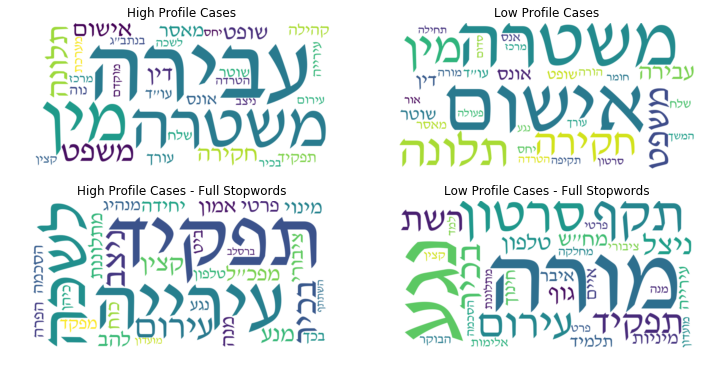

In [769]:
# create wordcloud objects
def create_wordcloud_obj(sorted_words):
    wc = WordCloud(background_color="white", width=1000, height=500,
                font_path='fonts/david.ttf', max_words=30, min_font_size=8, 
                normalize_plurals=False).generate_from_frequencies(sorted_words)
    return wc

wc_hp = create_wordcloud_obj(sorted_words_hp)
wc_lp = create_wordcloud_obj(sorted_words_lp)
wc_hp_fullsw = create_wordcloud_obj(sorted_words_hp_fullsw)
wc_hl_fullsw = create_wordcloud_obj(sorted_words_lp_fullsw)


# create figure
plt.figure(figsize=(12,6))
#plt.figure(figsize=(10,5))
plt.subplot(2,2,1)
plt.title('High Profile Cases')
plt.imshow(wc_hp, interpolation='bilinear')
plt.axis("off")

plt.subplot(2,2,2)
plt.title('Low Profile Cases')
plt.imshow(wc_lp, interpolation='bilinear')
plt.axis("off")

plt.subplot(2,2,3)
plt.title('High Profile Cases - Full Stopwords')
plt.imshow(wc_hp_fullsw, interpolation='bilinear')
plt.axis("off")

plt.subplot(2,2,4)
plt.title('Low Profile Cases - Full Stopwords')
plt.imshow(wc_hl_fullsw, interpolation='bilinear')
plt.axis("off")

plt.show()

### Analysis / Lawyer mentions 
How much space is given to lawyers, and what messages are highlighted by featuring them?

In [480]:
''' how many titles or full bodies include lawyer references '''

legal = ['עורכ דינ',
        'ערכ דינ',
        #'פרקליט', # removed because of praklitut (the state), reviewed separately below
        'סנגור',
        'עו"ד']


# find number of legal words in each article
legal_words = final_df['norm_words'].str.count('|'.join(legal))
full_legal_words = final_df['norm_full_text'].str.count('|'.join(legal))


print(f'Articles with some legal reference in title: {sum(legal_words > 0)} of {final_df.shape[0]} articles')
print(f'Articles with some legal reference in body: {sum(full_legal_words > 0)} of {final_df.shape[0]} articles')

Articles with some legal reference in title: 119 of 947 articles
Articles with some legal reference in body: 513 of 947 articles


In [1112]:
# separately looking at 'praklit' (attorney) that is not raised by the word 'praklitut' (prosecution)
# manually added them to the list below

count=0
for i in range(final_df.shape[0]):
    joint =  final_df.title.values[i] + ' ' +  final_df.subtitle.values[i] 
    prak = 'פרקליט'
    tut = 'פרקליטות'
    if prak in final_df.norm_words.values[i] and tut not in joint:
        count+=1
        #print(final_df.index[i], joint) # print titles to review and classify
    
print('total cases:', count) # 32

total cases: 32


#### Classifying titles and full data
Really bad: 46, 75, 81, 133, 189, 152, 197, 208, 252, 285, 340, 359, 367, 378, 467, 469, 480, 539, 552, 607, 
          576, 598, 636, 669, 678, 688, 728, 858, 869, 968, 1114, 1170

Denial, no mention of survivor: 74, 134, 138, 140, 142, 145, 170, 224, 245, 302, 314, 353, 356, 369, 375, 422, 454, 463, 465, 498, 499, 618, 623, 769, 809, 883, 901, 1036, 1083, 1140, 1280, 1289, 73, 353, 477, 598, 611, 771, 798, 1137, 1152, 1154, 1163, 1168, 1193, 1197, 1198, 1214, 1215, 1257

Victim: 79, 218, 315, 446, 509, 605, 844, 1053, 1131, 1146, 1172, 1192, 1197, 1241, 1242, 1259, 1273

Not applicable: 12, 85, 101, 117, 138, 146, 149, 202, 206, 232, 318, 384, 415, 416, 427, 440, 487, 572, 645, 717, 750, 770, 784, 817, 833, 835, 862, 912, 931, 980, 1030, 1034, 1035, 1038, 1039, 1062, 1067, 1129, 1228, 1229, 1278, 1292

#### Comments when working with 2019
Strong negative examples of bad practices: 1643, 2307, 2626, 2814

'He denies' but no voice for the victim: 1149, 1826, 2233, 2606, 2821, 3719, 3800, 4019, 4132

The lawyer of the victim: 1794, 1854, 1564, 2605, 2621, 3751, 3917

In [1113]:
bad= [46, 75, 81, 133, 189, 197, 208, 252, 285, 340, 359, 367, 378, 467, 469, 480, 539, 552, 607, 
          598, 636, 669, 678, 688, 728, 858, 869, 968, 1114, 1170]
#
neutral =[74, 134, 138, 140, 142, 145, 152, 170, 224, 245, 302, 314, 353, 356, 369, 375, 422, 454, 463, 465, 498, 499, 576, 618,
623, 769, 809, 883, 901, 1036, 1083, 1140, 1280, 1289, 73, 353, 477, 598, 611, 771, 798, 1137, 1152, 1154, 1163,
      1168, 1193, 1197, 1198, 1214, 1215, 1257, 1053]
      
# positive
victim = [79, 218, 315, 446, 509, 605, 844, 1131, 1146, 1172, 1192, 1197, 1241, 1242, 1259, 1273]
# NA
na=[12, 85, 101, 117, 138, 146, 149, 202, 206, 232, 318, 384, 415, 416, 427, 440, 487, 572, 645,
    717, 750, 770, 784, 817, 833, 835, 862, 912, 931, 980, 1030, 1034, 1035, 1038, 1039, 1062, 
    1067, 1129, 1228, 1229, 1278, 129]

# plus 10 because sometimes I just did not write a case if it was not bad/neutral/positive
print(f'distribution of cases - real bad: {len(bad)}, denial: {len(neutral)}, victim: {len(victim)}, NA: {len(na)+10}')

# print cases
# for i in bad:
#     hp = 'high profile' if final_df.loc[i,'high_profile']==1 else 'not high prof'
#     print(i, hp, final_df.loc[i,'dt_date'], '\n', final_df.loc[i,'title'] ,'\n', final_df.loc[i,'subtitle'])

distribution of cases - real bad: 30, denial: 53, victim: 16, NA: 52


#### Looking at the full contents and trying to extract something - no success

In [901]:
# same but with all articles that had legal quotes in body

# legal_indices = clean_df.index[full_legal_words>0].tolist()
# for i in legal_indices:
#     print(i, '\n', clean_df.loc[i,'full_text'])

In [902]:
# find the index of one of the legal words and get the text until the
# next period for compiling only lawyer references
# challenge - can't do it with not normalized because no periods and maybe before too. 
# let's start with a simplification of words before and after.

# buffer = 60
# for txt in final_df.norm_full_text.values[2:5]:
#     print()
#     for lgl in legal:
#         start_idx = txt.find(lgl)
#         if start_idx != -1:
#             print(txt[max(start_idx-buffer,0):min(start_idx+buffer, len(text))])

### Analysis / Gendered verbs - what did both sides do?

#### A. Look at one article

In [120]:
# find all verbs in a given row (title+subtitle)
row_id = 11 # the row to look at

# a long string and an array of words for that row
original_text = clean_df.title.values[row_id]+' '+clean_df.subtitle.values[row_id]
original_words = original_text.split(' ')

# get result from API
request = {'token': 'EGxhAVjlYSoRNsN', 'readable': False,
           'paragraph':  original_text}

result = requests.post('https://hebrew-nlp.co.il/service/Morphology/Analyze', json=request).json()

# array to store rows for a little dataframe that shows the 
# verb, gender, and sentence context to look at results closely
verbs=[]
word_id = 0

# iterate over all words in the result
for sentence in result:
     for word in sentence:
        best_option = word[0] # get the best-guess normalized word 
        if len(best_option['baseWord']) <= 1: # ignore punctuation
            continue
            
        if best_option['partOfSpeech'] == 'VERB':
            new_verb = { # create a new row
                'normalized' : best_option['baseWord'], # the verb
                'gender': best_option['gender'], # the gender
                'context': (' ').join(original_words[ # context in sentence
                    max(0,word_id-3):min(word_id+3, len(original_words))])
                }
            
            # add the suffix for feminine verbs for easy read
            if new_verb['gender']=='FEMALE' and new_verb['normalized'][-1]!='ה':
                new_verb['normalized'] = new_verb['normalized']+'ה'
            verbs.append(new_verb)
        word_id+=1

pd.DataFrame(verbs) 

,normalized,gender,context
0,הדל,BOTH,שידלו בת 13
1,ביצע,NONE,שידלו בת 13 לבצע אקט מיני
2,נעצר,BOTH,בשידור חי: 17 נעצרו בחשד לפדופיליה
3,נעצר,BOTH,מכל רחבי הארץ נעצרו בפשיטת המשטרה
4,יצר,BOTH,"פי החשד, הם יצרו קשר עם"
5,התחזה,BOTH,"קשר עם שוטרים שהתחזו לנערה, נהגו"
6,נהג,BOTH,"שוטרים שהתחזו לנערה, נהגו להתכתב איתה"
7,התכתב,NONE,"שהתחזו לנערה, נהגו להתכתב איתה ולשלוח"
8,שלח,NONE,"נהגו להתכתב איתה ולשלוח לה תמונות,"
9,הדל,BOTH,"תוכן מיני בוטה, וכן שידלו אותה"


#### Comments 
1. One complication is that even though with adults 99% of cases have a male perpetrator and female victim, with children victims (which are, unfortunately, a subset of cases) there are some male victims, and more rarely, female perpetrators. I might try to count exactly how many of such cases to understand if it's significant or just stands out most clearly.
2. Verbs can sometimes be associated with lawyers, police, court (praklitut) - makes it harder. Although these might even out - some of these are masculine and some feminine. maybe i'll have to count these to make sure it does. not sure it's THAT worth it.
3. Misidentifications by the linguistic analyzer - the word for lawyer has an embedded verb in it. Can be removed after when looking at the list, though. I don't think I'll do anything else except for that + acknowledging it. It doesn't look like it happens very often.
4. If there are multiple offenders, the verb comes up as 'both' because it's not gendered in plural. So that's one reason to think that the male verbs results actually underestimate the true numbers. 

#### B. Find verbs in all articles

In [974]:
def get_sorted_counts(all_verbs):
    '''Takes in an array of strings that contain all verbs separated by whitespaces
    returns a sorted count dictionary across all elements in the input array'''
    verbs_counts= {} # holds the result

    # for each collection of words
    for wrds in all_verbs: 
        # create a count dictionary for it 
        keys, values = np.unique(wrds.split(' '), return_counts=True)
        temp_dict = dict(zip(keys, values))

        # add it to the total counter 'word_counts'
        verbs_counts = {key: verbs_counts.get(key, 0) + temp_dict.get(key, 0)
              for key in set(verbs_counts) | set(temp_dict)}

     # remove an empty entry that gets created
    if '' in verbs_counts.keys():
        verbs_counts.pop('')
        
    sorted_ = sorted(verbs_counts.items(), key=lambda x: x[1], reverse=True) # sort by frequency
    return(sorted_)


In [ ]:
'''get sorted dictionaries - input file is achieved via scraping earlier or loaded in the commented line'''

# if loaded full_scraped_df from pickle
# full_m_verbs = full_scraped_df.full_m_verbs
# full_f_verbs = full_scraped_df.full_f_verbs

m_sorted=np.array(get_sorted_counts(full_m_verbs))
f_sorted=np.array(get_sorted_counts(full_f_verbs))

In [933]:
# explore results
# remove verbs that clearly do not talk about either person but the investigation or police 
# or criminal aspects are generic like 'was' and 'said' (most frequent for both)
# I kept denied and confessed to compare. Inclusins are stopwords that this time I want 
# to include, like 'shouted' and 'was hurt'.

# define specific inclusions that differ from the stopwords and exclusions to this section
include = ['נפגע', 'צעק' , 'אנס' , 'נאנס' , 'הכחיש' , 'הודה' , 'שכב', 'קיימ']
exclude = ['פרסמ', 'הורה', 'מינה' , 'שלח', 'פורסמ', 'הורחק', 'השתמש', 'נשלח', 'זכר', 'חיה', 'התלוננ', 'נעצר', 'פרסמ', 'הצביע', 'אהב', 'נותר',
          'סיפק' , 'הקצינ', 'הספיק', 'חיזק', 'נעמ', 'ירד', 'זנ', 'הסתיימ']

def verbs_remove_stopwords(gender, verbs_sorted, include, exclude, stopwords):
    ''' remove stopwords from the verbs lists and apply the include and exclude lists above.
        And in fact, it is also used with adjectives later - whatever is sorted in the same format'''
    
    remov=[] # indices to remove
    # iterate over all sorted word counts
    for i,txt in enumerate(verbs_sorted):
        # if currently looking at masculine things, check the word as is
        if gender=='M':  
            if (txt[0] in stopwords and txt[0] not in include) or txt[0] in exclude:
                remov.append(i) # add for removal
                
        # if looking at feminine ones, look at the word without the last letter bc normalization
        if gender=='F':
            if (txt[0][:-1] in stopwords and txt[0][:-1] not in include) or txt[0][:-1] in exclude:
                remov.append(i)

    # remove everything in remov
    sorted_filtered = np.array([(i[0],i[1]) for j, i in enumerate(verbs_sorted) if j not in remov])
    return sorted_filtered

# apply filtering
m_sorted_filtered = verbs_remove_stopwords('M', m_sorted, include, exclude, norm_stopwords_full)
f_sorted_filtered = verbs_remove_stopwords('F', f_sorted, include, exclude, norm_stopwords_full)

#### C. Plot top 20 for full article content

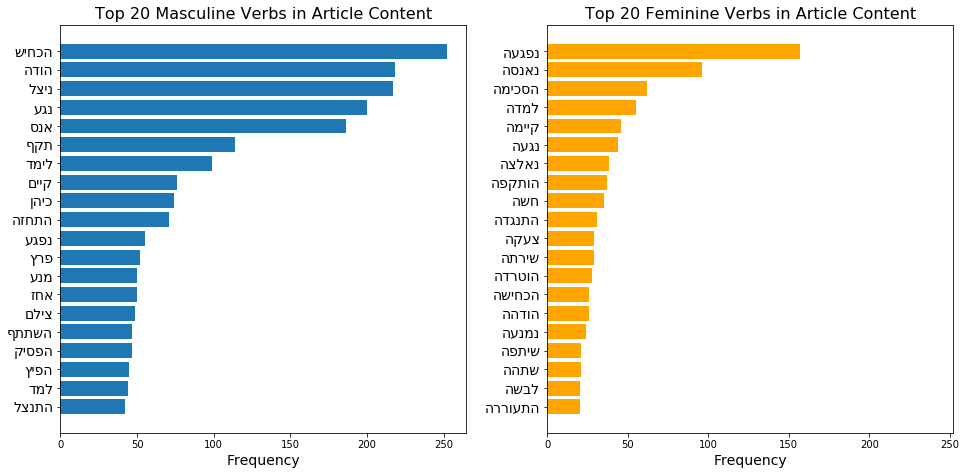

In [937]:
# print bar plots

def plot_sorted_fm(f_sorted, m_sorted, title, topN, where):
    # make lists with the verbs and frequencies
    m_verbs = [get_display(final_letter(_)) for _ in m_sorted[:topN,0]]
    m_counts = m_sorted[:topN,1].astype(int)

    f_verbs = [get_display(final_letter(_)) for _ in f_sorted[:topN,0]]
    f_counts = f_sorted[:topN,1].astype(int)

    # make figure
    fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(16,7.5))

    # masculine side
    ax1.barh(np.arange(len(m_verbs)), m_counts)
    ax1.set_yticklabels(m_verbs, fontsize=14)
    ax1.set_yticks(np.arange(len(m_verbs)))
    ax1.invert_yaxis()  # labels read top-to-bottom
    ax1.set_xlabel('Frequency', fontsize=14)
    ax1.set_title(f'Top {topN} Masculine {title} in {where}', fontsize=16)

    # feminine side
    ax2.barh(np.arange(len(f_verbs)), f_counts, color='orange')
    ax2.set_xlim(0,max(m_counts))
    ax2.set_yticklabels(f_verbs, fontsize=14)
    ax2.set_yticks(np.arange(len(f_verbs)))
    ax2.invert_yaxis()  # labels read top-to-bottom
    ax2.set_xlabel('Frequency', fontsize=14)
    ax2.set_title(f'Top {topN} Feminine {title} in {where}', fontsize=16)
    plt.show()
    
plot_sorted_fm(f_sorted_filtered, m_sorted_filtered, 'Verbs', 20, 'Article Content')

In [944]:
# Total number of M vs F

# this is hard to interpret even after I removed some verbs because I didn't do it comprehensively 
# but generally, 'police' and 'prosecution' (who press charges) are feminine, while the court is masculine, 
# and these are the main actors, so I estimate the gap in 'who's the focus' is at least as big.

print('Top 20 sums M | F')
print(sum(m_sorted_filtered[:20,1].astype(int)), sum(f_sorted_filtered[:20,1].astype(int)))
print('Full list M | F')
print(sum(m_sorted_filtered[:,1].astype(int)), sum(f_sorted_filtered[:,1].astype(int)))

Top 20 sums M | F
1988 845
Full list M | F
9140 4421


#### D. same but only for titles - pretty similar

In [945]:
### Titles - clean and plot - not very difference so commented out
# load full_scraped_df from pickle before analysis if this is undefined
# titles_m_verbs = full_scraped_df.titles_m_verbs
# titles_f_verbs = full_scraped_df.titles_f_verbs

# Clean
# m_sorted_titles=np.array(get_sorted_counts(titles_m_verbs))
# f_sorted_titles=np.array(get_sorted_counts(titles_f_verbs))

# m_sorted_filtered_titles = verbs_remove_stopwords('M', m_sorted_titles, include, exclude, norm_stopwords_full)
# f_sorted_filtered_titles = verbs_remove_stopwords('F', f_sorted_titles, include, exclude, norm_stopwords_full)

# # plot
# plot_sorted_fm(f_sorted_filtered_titles, m_sorted_filtered_titles, 'Verbs', 20, 'Titles')

#### E. Separating high and low profile - full content

In [1043]:
# if need, load full_scraped_df from pickle before analysis section
# full_m_verbs = full_scraped_df.full_m_verbs
# full_f_verbs = full_scraped_df.full_f_verbs

# indicies of high profile cases
hp_indices = np.where(final_df.high_profile)[0]
the_rest = np.where(final_df.high_profile==0)[0]

# split the result verbs above by these indices
# here every element is still a string with all verbs found in the content 
full_m_verbs_hp = np.array(full_m_verbs)[hp_indices]
full_f_verbs_hp = np.array(full_f_verbs)[hp_indices]
full_m_verbs_nothp = np.array(full_m_verbs)[the_rest]
full_f_verbs_nothp = np.array(full_f_verbs)[the_rest]

# Sorted counts for all verbs across the articles
m_sorted_v_hp=np.array(get_sorted_counts(full_m_verbs_hp))
f_sorted_v_hp=np.array(get_sorted_counts(full_f_verbs_hp))
m_sorted_v_nothp=np.array(get_sorted_counts(full_m_verbs_nothp))
f_sorted_v_nothp=np.array(get_sorted_counts(full_f_verbs_nothp))

# make dedicated lists with the verbs that pop up in high-profile cases and are irrelevant
include_hp = ['נפגע', 'צעק' , 'אנס' , 'נאנס' , 'הכחיש' , 'הודה' , 'שכב', 'קיימ', 'הטריד']

exclude_hp = ['פרסמ', 'הורה', 'מינה' , 'שלח', 'פורסמ', 'ירה' , 'השתחרר', 'טייפ', 'נשאר', 'התכוונ', 'נימק', 'נבנה', 'נשקפ', 'התרשמ' , 'התמקד',
              'הורחק', 'השתמש', 'נשלח', 'זכר', 'חיה', 'התלוננ', 'נעצר', 'פרסמ', 'הצביע', 'אהב', 'נותר', 'נכלל', 'בירכ', 'אבטח', 'נהר', 'ספג',
              'סיפק' , 'הקצינ', 'הספיק', 'חיזק', 'נעמ', 'ירד', 'זנ', 'הסתיימ', 'חרט', 'חרטה', 'שר', 'הצדיק', 'הועמד', 'שוחח', 'חמ', 'פרצ',
             'הוסגר', 'מנע', 'הדליק', 'התבקש', 'השלימ', 'שיתפ', 'יועד', 'הוקלט', 'איבד', 'הוכנ', 'ליווה', 'הועד']

# remove stopwords
m_sorted_filtered_v_hp = verbs_remove_stopwords('M', m_sorted_v_hp, include_hp, exclude_hp, norm_stopwords_full)
f_sorted_filtered_v_hp = verbs_remove_stopwords('F', f_sorted_v_hp, include_hp, exclude_hp, norm_stopwords_full)
m_sorted_filtered_v_nothp = verbs_remove_stopwords('M', m_sorted_v_nothp, include_hp, exclude_hp, norm_stopwords_full)
f_sorted_filtered_v_nothp = verbs_remove_stopwords('F', f_sorted_v_nothp, include_hp, exclude_hp, norm_stopwords_full)

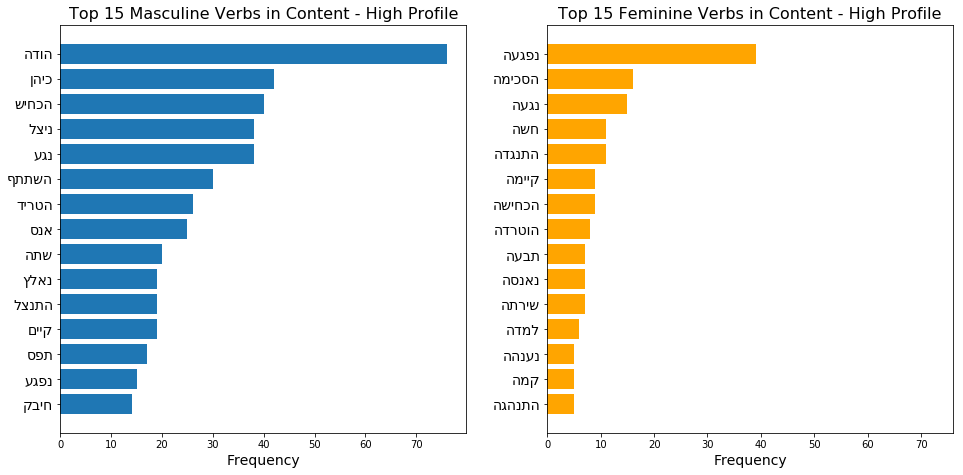

In [1044]:
# # plot - HP
plot_sorted_fm(f_sorted_filtered_v_hp, m_sorted_filtered_v_hp, 'Verbs', 15, 'Content - High Profile')

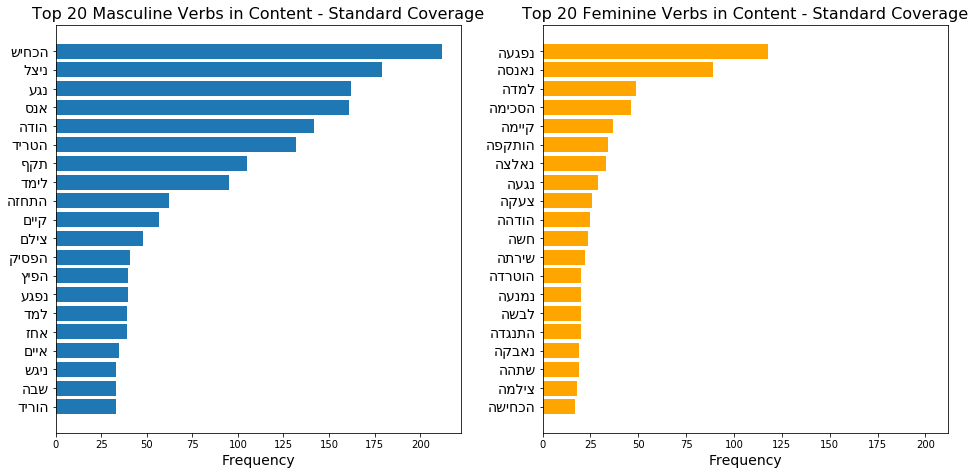

In [1018]:
# # plot - the rest - very similar to the full figure but used these counts when making comparison
plot_sorted_fm(f_sorted_filtered_v_nothp, m_sorted_filtered_v_nothp, 'Verbs', 20, 'Content - Standard Coverage')

In [1040]:
# count frequency M v F
print('Top 20 sums M | F')
print(sum(m_sorted_filtered_v_hp[:15,1].astype(int)), sum(f_sorted_filtered_v_hp[:15,1].astype(int)))
print('Full list M | F')
print(sum(m_sorted_filtered_v_hp[:,1].astype(int)), sum(f_sorted_filtered_v_hp[:,1].astype(int)))

Top 20 sums M | F
438 160
Full list M | F
2310 900


In [1028]:
# not in the writeup - comparing active vs passive raped - hp
print('high profile')
print(m_sorted_filtered_v_hp[7], f_sorted_filtered_v_hp[12])

# active vs pasisice - standard
print ('standard coverage')
print(m_sorted_filtered_v_nothp[3], f_sorted_filtered_v_nothp[1])

# when doing a significance test with these proportions and sample sizes, the result is not significant at 0.05
# i.e. this could just be due to change (makes sense because of the small high-profile sample size)

high profile
['אנס' '25'] ['נאנסה' '7']
standard coverage
['אנס' '161'] ['נאנסה' '89']


### Analysys / Gendered Adjectives

how are perpetrator/victim described?
 
This section uses the exact same process as the verb one, and the same functions.

In [673]:
# load full_scraped_df from pickle
# full_m_adj = full_scraped_df.full_m_adj
# full_f_adj = full_scraped_df.full_f_adj

# Get counts and sort
m_sorted_adj=np.array(get_sorted_counts(full_m_adj))
f_sorted_adj=np.array(get_sorted_counts(full_f_adj))

# change to the corrent suffix for most feminine adjectives
for i in range(len(f_sorted_adj)):
    f_sorted_adj[i][0] = f_sorted_adj[i][0][:-1] + 'ת'

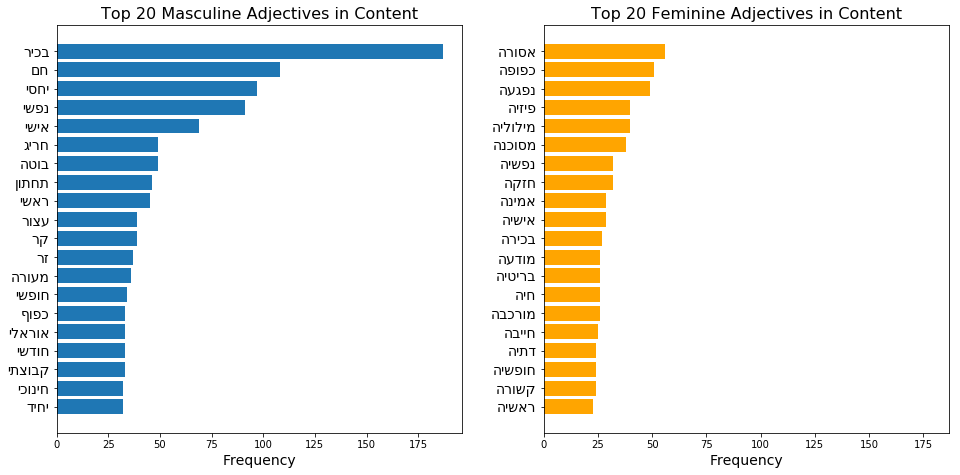

In [1032]:
### Adjectives full content - clean and plot

# remove stuff
# define specific inclusions that differ from the stopwords and exclusions to this section
include_adj = [] #['נפגע', 'צעק' , 'אנס' , 'נאנס' , 'הכחיש' , 'הודה' , 'שכב', 'קיימ']
exclude_adj = ['נייד', 'דומה' , 'מוקדמ', 'ראייתי', 'קיימ', 'רב', 'חשוד', 'ארוכ', 'ציבורי', 'שונה', 'ארכ', 'רש', 'ישראלי', 'נוגע', 'מסוימ', 
               'מקומי', 'חברתי' , 'מחמיר', 'חרד', 'משטרתי', 'משותפ', 'סוציאלי', 'חמור', 'פרטי', 'ארצי', 'סגור', 'פסיכיאטרי', 'משמעותי',
              'משמעתי', 'חוקי', 'ראשוני', 'אינטימי', 'מיוחס', 'מיוחד', 'לאומני', 'סבור', 'הולמ', 'סמוי', 'מקצועי']

m_adj_filtered = verbs_remove_stopwords('M', m_sorted_adj, include_adj, exclude_adj, norm_stopwords_full)
f_adj_filtered = verbs_remove_stopwords('F', f_sorted_adj, include_adj, exclude_adj, norm_stopwords_full)

# plot
plot_sorted_fm(f_adj_filtered, m_adj_filtered, 'Adjectives', 20, 'Content')

#### Comments
After looking at all male ones, even after adding more and more stopwords, most of the most frequent ones are not clearly about the person. So might be worth searching for specific words and exploring them.

indices by row number of interesting cases

normative (205, 128, 134, 2 - although all quotes) - 243 (pretty intense responses about false reporting for case closed for lack of evidence), 419 (some lawyer victim questioning as well), 626, 771 (lawyer), 875 876 (lawyer, kids), 940

muarach (187, 183, 124, 46) - 130 with some victim-blaming from lawyer, 149 (plus ahuv), 294 308 (buchris), 422 (best example), 446 lawyer, 484, 873, 913 925, 928 (kosovski),  69

mitztayen - 161, 451, 653

## Analysis / Topic model

The code for training the model itself is in a separate notebook, 'topic_kulan'. The code below uses an outcome dataframe produced there, which has the two principal components for plotting, the main topic classification, and a marker indicator for high-profile vs standard coverage. 

In [884]:
# the topic model loaded the files based on their ordering in the filesystem
# which is not 1,2,3 but 1, 10, 11, 12, 2, 21, 3. So I had to order the df
# that has the article data to the order that the topic model uses so that 
# the topics match their articles. 

import os
nothp = os.listdir('./textfiles/textfiles_norm_full_nothp')
nums = list(map(lambda sub:int(''.join( 
      [ele for ele in sub if ele.isnumeric()])), nothp)) 

hp = os.listdir('./textfiles/textfiles_norm_full_hp')
nums2 = list(map(lambda sub:int(''.join( 
      [ele for ele in sub if ele.isnumeric()])), hp)) 

# this is the order in which the dataset should be order to match the topics
right_order= np.concatenate([nums, nums2])

# load dataframe from topic model script
topic_model_df  = pd.read_pickle("./data/topicmodel.p") 
topic_final_df = final_df.drop([209, 681]) # remove two articles with empty content

# fix order to match the order of files in the folder
topic_final_df = topic_final_df.reindex(right_order)

In [885]:
# adding the topic_df columns to the main dataframe 

# Principal Component 1 - the X axis
topic_final_df.loc[:,'PC1'] = topic_model_df.PC1.to_numpy()

# Principle Component 2 - the y axis (both from using PCA on the five-dimenesional data)
topic_final_df.loc[:,'PC2'] = topic_model_df.PC2.to_numpy()

# the dominant topic of the article (numeric)
topic_final_df.loc[:,'main_topic'] = topic_model_df.main_topic.to_numpy()

# a marker to separate high profile cases
topic_final_df.loc[:,'high_profile_marker'] = topic_model_df.high_profile.to_numpy()

# Set topic names that are not numbers
topicnames = ["Internet Crimes","Assault Descriptions","Public Authorities","Police/Army","School"]
main_topic_str = [topicnames[i] for i in topic_model_df.main_topic.values.astype(int)]

topic_final_df.head()

,title,subtitle,reporter,link,norm_words,full_text,norm_full_text,high_profile,dt_date,year,month,PC1,PC2,main_topic,high_profile_marker
original_index,,,,,,,,,,,,,,,
0,אישום: אנס את אחותו מגיל חמש - וגרם לה לבלוע ת...,"תושב המרכז, בן 29, מואשם בשורה של עבירות מין ב...",גלי גינת,https://news.walla.co.il/item/2930403,אישומ אנס את אח גיל חמש גרמ בלע תרופה כדי מת ת...,"תושב המרכז, בן 29, מואשם בשורה של עבירות מין ב...",תושב מרכז הואשמ שורה עבירה מינ מעשה סדומ עוד ה...,0,2016-01-31 10:10:00,2016,1,-0.603072,-0.363158,2,circle
1,"אחרי שלושה חודשים: נסגר תיק החקירה בפרשת ""אלנב...",פרקליטות תל אביב הודיעה לחשודים כי החליטה לסגו...,גלי גינת,https://news.walla.co.il/item/2929998,אחרי שלוש חודש נסגר תיק חקירה פרשה אלנבי 40 פר...,פרקליטות תל אביב הודיעה לחשודים כי החליטה לסגו...,פרקליטות אביב הודיע חשוד החליט סגר תיק נגד הוד...,0,2016-01-28 18:07:00,2016,1,-0.191281,-0.275265,2,circle
1000,הציע טרמפ לקטינה - ואנס: תושב הדרום מואשם בחט...,"לאחר ויכוח עם חבריו בפארק בבאר שבע, הבטיח חליל...",יניר יגנה,https://news.walla.co.il/item/3201589,הציע טרמפ קטינ אנס תושב דרומ הואשמ חטיפה בת לא...,"לאחר ויכוח עם חבריו בפארק בבאר שבע, הבטיח חליל...",לאחר ויכוח חבר פארק באר שבע הבטיח חליל רביע קט...,0,2018-11-19 13:43:00,2018,11,0.671467,-0.396413,4,circle
1001,"שנת מאסר לצעיר שהפיץ סרטונים מיניים: ""פגיעה חמ...",העליון קיבל את ערעור הפרקליטות והחמיר את עונשו...,מאיה הורודניצ'אנו,https://news.walla.co.il/item/3201427,שנה מאסר צעיר הפיצ סרטונ מיני פגיעה חמור ממשי ...,העליון קיבל את ערעור הפרקליטות והחמיר את עונשו...,עליונ קיבל ערעור פרקליטות החמיר עונש אספ דננ ה...,0,2018-11-18 20:45:00,2018,11,0.411895,-0.412315,4,circle
1002,"""יום שישי הכחול"": סרטון מיני הוקרן בשלט חוצות ...",אזרחים שנסעו בכביש 22 סמוך לקניון חוצות המפרץ ...,יואב איתיאל,https://news.walla.co.il/item/3201106,יומ שש כחול סרטונ מיני הוקרנ שלט חוצות לב חיפה...,אזרחים שנסעו בכביש 22 סמוך לקניון חוצות המפרץ ...,אזרח נסע כביש סמוכ קניונ חוצות מפרצ עיר הבחינ ...,0,2018-11-16 22:54:00,2018,11,0.664259,-0.390988,4,circle


In [886]:
# modify subtitle to have line breaks for hover (not working yet)
topic_final_df.loc[:,'subtitle_hover'] = topic_final_df.subtitle.str.wrap(20)
#topic_final_df.subtitle_hover = topic_final_df.subtitle_hover.apply(lambda x: x.replace('. ', '.<br>'))

In [1137]:
# export for visualizaiton with Flourish
topic_final_df.loc[:,'main_topic_str'] = main_topic_str
topic_final_df.to_csv('topic_for_plot.csv')

In [1139]:
# show visualization made in Flourish
# also here: https://public.flourish.studio/visualisation/4711320/
viz = '<div class="flourish-embed flourish-scatter" data-src="visualisation/4711320"><script src="https://public.flourish.studio/resources/embed.js"></script></div>'
display(HTML(viz))

## Utility

### Utility / Save articles to text file for loading in elsewhere (e.g. Voyant)

Nothing new came out of Voyant, unfortunately.

In [408]:
# save text files 
for i in final_df.index.values:
    hp = final_df.loc[i,'high_profile']
    # separate high profile and standard coverage 
    if hp==1:
        fname = f'textfiles/textfiles_norm_full_hp/article{i}.txt'
    else:
        fname= f'textfiles/textfiles_norm_full_nothp/article{i}.txt'
        
    text = final_df.loc[i,'norm_full_text']
    if len(text)>0: # weird error in some reports
        with open(fname, "w", encoding="utf-8") as f:
            f.write(text)

search mentions of 'drank', 'wore', 'drunk' --> quick search did not yield much
can't search what was the subject of a sentence, sadly

### Utility / Testing HebrewNLP - Tokenize, Normalize, Analyze

In [1130]:
# # Tokenize - separate text to words and nikud.

# request = {
#     'token': 'EGxhAVjlYSoRNsN',
#     'text': clean_df.subtitle.values[48]
# }

# result = requests.post('https://hebrew-nlp.co.il/service/preprocess/tokenizer', json=request).json()

# print(clean_df.subtitle.values[48])
# print(result)

In [1129]:
# # Hebrew-NLP Normalize - also runs sentencer and tokenizer
# # -- it turns numbers into a #
# # -- nikud is a problem with this one

# test_text = ['אנס', 'באונס', 'שנאנסה']
# request = {
#     'token': 'EGxhAVjlYSoRNsN',
#     # Normalize:
#     'type': 'SEARCH',
#     'sentences': test_text # text if full text
# }

# result = requests.post('https://hebrew-nlp.co.il/service/Morphology/Normalize', json=request).json()

# print(result)
# 'אנס' in result

In [1128]:
# # Hebrew-NLP Analyze

# #relevant_words = 'עורך דין פרקליט סנגור עו"ד '
# relevant_words = 'החשוד תקף את הנערה, הנערה נאנסה על ידי החשוד'
# request = {
#     'token': 'EGxhAVjlYSoRNsN',
#     'readable': False,
#     'paragraph':  relevant_words
# }

# result = requests.post('https://hebrew-nlp.co.il/service/Morphology/Analyze', json=request).json()

# for sentence in result:
#     for word in sentence:
#         best_option = word[0]
#         print(f"{best_option['baseWord']} - {best_option['partOfSpeech']}") 

In [1126]:
#result

In [1127]:
# Examine the type of information recieved per word
# -- can access both with and without nikud
# -- gender
#result[0][1][0] , result[0][6][0]